
On doit télécharger : BDTOPO Tous themes gkpg septembre 2025 : https://geoservices.ign.fr/bdtopo? pour les routes 
et https://cerema.app.box.com/s/80h1p9q62get6rnvhr051sesb4chg4z0/folder/268532500070 pour les bâtiments


Pour les routes : ouvrir le document au format gkpg sur Qgis. On a besoin de la couche tronçons de route (il faut plus de 200 000 entités pour l'oise pour avoir bien accès au réseau secondaire)
Autre problème : le code commune insee des routes ne correspond pas au code commune insee des communes
On ne l'utilise donc pas et on fera une sélection géométrique plus tard.

Traiter sur qgis pour mettre la géométrie : ouvrir la table d'attribut : calculatrice de champ, ajouter un champ : geom_groupe, sélectionner le format texte de longueur 0 puis taper   geom_to_wkt($geometry)dans le calculateur et appuyer sur ok. Patientez sans toucher à rien puis quitter la table d'attributs.
Exporter le document au format csv en n'exportant que geom_groupe (déselectionner toutes les autres colonnes)

Pour les bâtiments : dep{departement}_enrezo_besoins.zip à télécharger, ouvrir le document .shp sur qgis. Puis même procédure que précédemment pour récupérer la géométrie, mais on ne peut entrer que geom_group (limite de caractères, corrigé plus loin). Lors de l'export csv, conserver toutes les données cette fois-ci. 

On utilisera surtout "COM_INSEE", "CHAUF_MWH", "ECS_MWH", "geom_group" qui sont respectivemment le code commune insee, la consommation annuelle d'énergie de chauffage en MWh, la consommation annuelle d'énergie d'eau chaude sanitaire en MWh et les coordonnées. 




In [2]:
#Routes général
import pandas as pd
liste_colonnes_global_routes= ["geom_groupe"]

departement="09"
# Lecture
global_path_roads=f"/Users/louisedeferran/Documents/Louise/Mines/effynersys/reseau_chaleur/DHN_Potential_France_EFFINERSYS/data_basis/depart_{departement}/routes_{departement}.csv"

df_glob = pd.read_csv(global_path_roads, sep=",", engine="python")


df_glob = df_glob[liste_colonnes_global_routes]
print(df_glob.columns.tolist())


print(df_glob.head())       
df_glob.to_csv(f"/Users/louisedeferran/Documents/Louise/Mines/effynersys/reseau_chaleur/DHN_Potential_France_EFFINERSYS/data_basis/depart_{departement}/final_routes_{departement}.csv", index=False)

['geom_groupe']
                                         geom_groupe
0  LineStringZ (628613 6174481.5 1428.7, 628622.3...
1  LineStringZ (628565.3 6174450 1430.5, 628577.8...
2  LineStringZ (628590 6174470.3 1429.4, 628601.4...
3  LineStringZ (635575.3 6174040.6 2003.3, 635588...
4  LineStringZ (629194.4 6174458.4 1377.8, 629189...


In [1]:
from pyproj import Transformer
from shapely.ops import transform
from shapely import wkt
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from shapely.geometry import LineString, MultiLineString, Polygon, MultiPolygon, box 

### Test global pour vérifier le bon fonctionnement

Code commune Insee retenu : 95018
Commune sélectionnée : Argenteuil
17274 bâtiments ont été retenus pour la commune Argenteuil (95018).
227445 routes ont été retenues.
Le nombre final de bâtiments retenus est de 17274.
La demande totale en chaleur est de 406.23 GWh/an.
Le plus gros bâtiment a une demande de 2931.00 MWh/an.
Le nombre final de bâtiments retenus après application de E_MAX_DEF est de 929.


/var/folders/7q/1g8c6vbj47ndz60jzpr7xn7h0000gn/T/ipykernel_1353/847821943.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_buildings_sorted_final["centroids"]= centroids


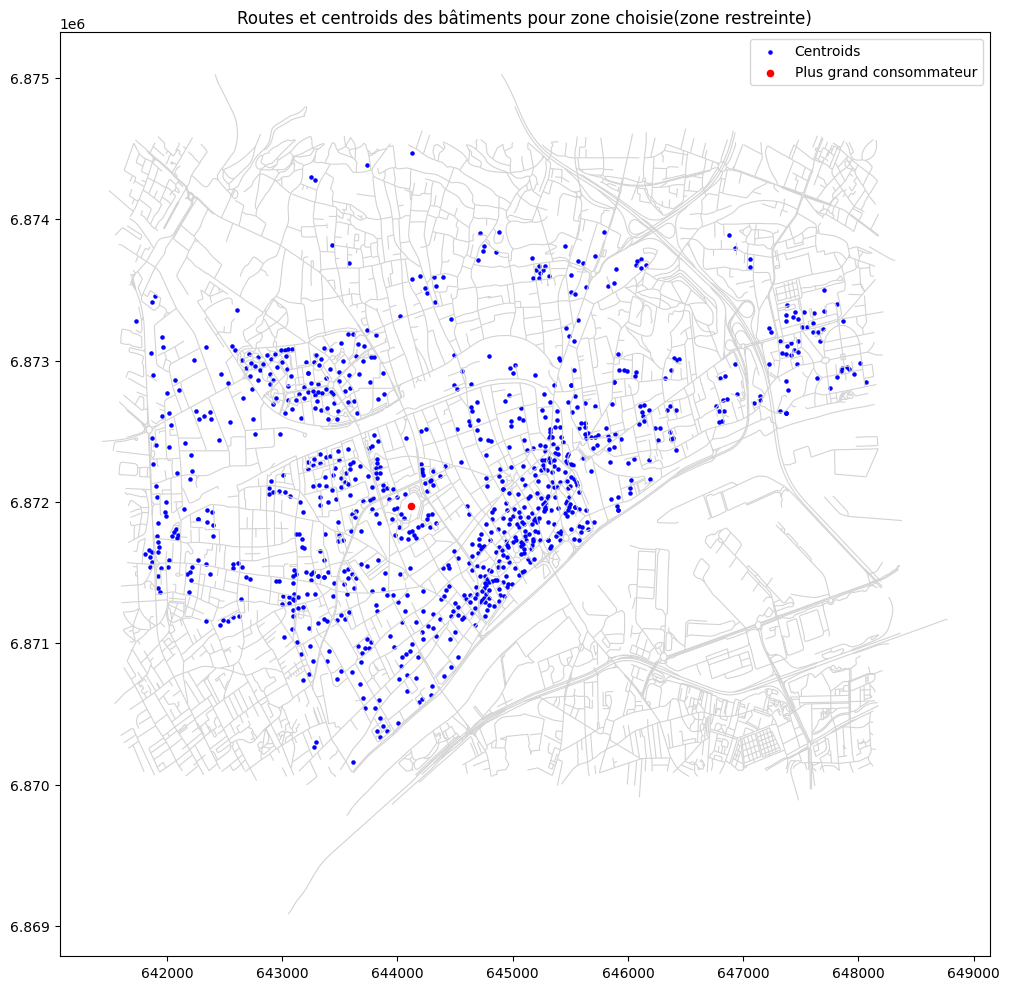

In [8]:
# Chemins vers les fichiers GeoPackage

departement=input("Departement : ")
liste_colonnes_global_routes= ["geom_groupe"]

buildings_file = f"/Users/louisedeferran/Documents/Louise/Mines/effynersys/reseau_chaleur/DHN_Potential_France_EFFINERSYS/data_basis/depart_{departement}/conso_coords_{departement}.csv"

global_path_roads=f"/Users/louisedeferran/Documents/Louise/Mines/effynersys/reseau_chaleur/DHN_Potential_France_EFFINERSYS/data_basis/depart_{departement}/routes_{departement}.csv"
df_glob = pd.read_csv(global_path_roads, sep=",", engine="python")
df_glob = df_glob[liste_colonnes_global_routes]
df_glob.to_csv(f"/Users/louisedeferran/Documents/Louise/Mines/effynersys/reseau_chaleur/DHN_Potential_France_EFFINERSYS/data_basis/depart_{departement}/final_routes_{departement}.csv", index=False)


roads_file = f"/Users/louisedeferran/Documents/Louise/Mines/effynersys/reseau_chaleur/DHN_Potential_France_EFFINERSYS/data_basis/depart_{departement}/final_routes_{departement}.csv"



# Charger avec le séparateur correct
df_buildings= pd.read_csv(buildings_file, sep=',', dtype=str, on_bad_lines='skip', encoding='utf-8')

roads_df = pd.read_csv(roads_file, sep=',', dtype=str, on_bad_lines='skip', encoding='utf-8')


df_buildings_copie=df_buildings[["COM_INSEE", "CHAUF_MWH", "ECS_MWH", "geom_group"]].copy()
df_buildings_copie.rename(columns={"CHAUF_MWH": "conso_ref_chauf_MWh", "ECS_MWH": "conso_ref_ecs_MWh", "COM_INSEE": "code_commune_insee", "geom_group" : "geom_groupe"}, inplace=True)

df_buildings_copie["conso_ref_tot_MWh"] = df_buildings_copie["conso_ref_chauf_MWh"].astype(float) + df_buildings_copie["conso_ref_ecs_MWh"].astype(float)

#filtrage des propriétés : enlever les Na partout
df_buildings_copie = df_buildings_copie.dropna(subset=["conso_ref_chauf_MWh", "geom_groupe", "code_commune_insee"])


#Indiquer le libellé d'une commune à partir de son code INSEE
communes_insee_file="/Users/louisedeferran/Documents/Louise/Mines/effynersys/reseau_chaleur/DHN_Potential_France_EFFINERSYS/data_basis/insee_communes_2024.csv"
communes_insee = pd.read_csv(
    communes_insee_file,
    dtype=str,
    sep='","',
    engine='python'
)

# Nettoyage des guillemets
communes_insee.columns = communes_insee.columns.str.replace('"', '')
communes_insee = communes_insee.apply(lambda c: c.str.replace('"', '', regex=False))

# Séparer TYPECOM et COM
communes_insee[['TYPECOM', 'COM']] = communes_insee['TYPECOM,COM'].str.split(',', expand=True)

# Supprimer l’ancienne colonne cassée
communes_insee = communes_insee.drop(columns=['TYPECOM,COM'])


# Sélection + renommage
communes_insee_copie = communes_insee[["COM", "LIBELLE"]].copy()
communes_insee_copie = communes_insee_copie.rename(
    columns={
        "COM": "code_commune_insee",
        "LIBELLE": "libelle_commune_insee"
    }
)
#enlever le 0 devant les codes insee si besoin
#communes_insee_copie["code_commune_insee"] = communes_insee_copie["code_commune_insee"].str.lstrip("0")

#ajouter la colonne libellé commune dans df_buildings_copie
df_buildings_copie = df_buildings_copie.merge(
    communes_insee_copie,
    on="code_commune_insee",
    how="left"
)

# Groupement par commune
buildings_by_commune = {
    commune: df.reset_index(drop=True)
    for commune, df in df_buildings_copie.groupby("code_commune_insee")
}
# Demande du code postal de la ville/lieu à étudier


def find_libelle_commune(code_commune):
    #buildings_df = pd.read_csv(buildings_file, dtype={'ban_code_commune_insee': str})
    
    matching_rows = buildings_by_commune.get(code_commune, pd.DataFrame())
    
    if not matching_rows.empty:
        libelle_commune = matching_rows.iloc[0]['libelle_commune_insee']
        return libelle_commune
    else:
        
        return None

#prendre la commune avec le plus de bâtiments
commune_counts = df_buildings_copie['code_commune_insee'].value_counts()
code_commune_insee = commune_counts.idxmax()

libelle_commune = find_libelle_commune(code_commune_insee)

print(f"Code commune Insee retenu : {code_commune_insee}")
print(f"Commune sélectionnée : {libelle_commune}")

# Extraction des bâtiments

df_selected_buildings=buildings_by_commune.get(code_commune_insee, pd.DataFrame())

print(f"{len(df_selected_buildings)} bâtiments ont été retenus pour la commune {libelle_commune} ({code_commune_insee}).")

# Extraction des routes
roads = []  # bâtiments qui seront considérés pour le RCU
n = len(roads_df)

for road in range(n):
    properties = roads_df.iloc[road].to_dict()


    if pd.notna(properties["geom_groupe"]):
        roads.append(road)

print(len(roads), "routes ont été retenues.")
df_selected_roads = roads_df.iloc[roads]


transformer = Transformer.from_crs(
    "EPSG:4326",
    "EPSG:2154",
    always_xy=True
)

def reproject_wkt(wkt_geom, transformer):
    try:
        geom = wkt.loads(wkt_geom)
        return transform(transformer.transform, geom)
    except Exception:
        return None
    
df_selected_buildings["geom_proj"] = df_selected_buildings["geom_groupe"].apply(
    lambda x: reproject_wkt(x, transformer)
)



sorted_index_hab = np.argsort(df_selected_buildings["conso_ref_tot_MWh"])[::-1]

df_buildings_sorted = df_selected_buildings.iloc[sorted_index_hab]
#reset index
df_buildings_sorted = df_buildings_sorted.reset_index(drop=True)

print(f"Le nombre final de bâtiments retenus est de {len(df_buildings_sorted['conso_ref_tot_MWh'])}.")
print(f"La demande totale en chaleur est de {np.sum(df_buildings_sorted['conso_ref_tot_MWh'])/1e3:.2f} GWh/an.")
print(f"Le plus gros bâtiment a une demande de {df_buildings_sorted['conso_ref_tot_MWh'].iloc[0]:.2f} MWh/an.")


E_MAX_DEF=58  #MWh/an
df_buildings_sorted_final=df_buildings_sorted[df_buildings_sorted["conso_ref_tot_MWh"]>=E_MAX_DEF]

print(f"Le nombre final de bâtiments retenus après application de E_MAX_DEF est de {len(df_buildings_sorted_final['conso_ref_tot_MWh'])}."    )

def get_centroid_geom(geom):
    if geom is None:
        return None
    if isinstance(geom, MultiPolygon):
        geom = max(geom.geoms, key=lambda p: p.area)
    if isinstance(geom, Polygon):
        c = geom.centroid
        return c.x, c.y
    return None

# Fonction pour transformer LineString / MultiLineString en segments XY
def extract_lines_xy(wkt_geom):
    try:
        geom = wkt.loads(wkt_geom)
    except Exception:
        return []  # géométrie invalide

    segments = []

    if isinstance(geom, LineString):
        coords_2d = [(c[0], c[1]) for c in geom.coords]
        segments.append(coords_2d)
    

    elif isinstance(geom, MultiLineString):
        for line in geom.geoms:
            coords_2d = [(c[0], c[1]) for c in line.coords]
            segments.append(coords_2d)

    return segments

# Filtrer les segments de routes à l'intérieur du bounding box
def filter_segments(segment, min_x, max_x, min_y, max_y):
    x, y = zip(*segment)  # segment est une liste de tuples (x, y)
    x = np.array(x)
    y = np.array(y)
    return ((x >= min_x) & (x <= max_x) & (y >= min_y) & (y <= max_y)).any()

# Extraction des segments pour toutes les routes
all_segments = []
for geom_wkt in df_selected_roads["geom_groupe"]:
    all_segments.extend(extract_lines_xy(geom_wkt))

# Extraire les centroids des bâtiments
centroids = df_buildings_sorted_final["geom_proj"].apply(get_centroid_geom).dropna()
df_buildings_sorted_final["centroids"]= centroids
centroids = list(centroids)
if centroids:
    centroids_x, centroids_y = zip(*centroids)
else:
    centroids_x, centroids_y = [], []

# Définir la zone des bâtiments (bounding box) car toutes les routes ne sont pas nécessaires
if centroids_x:
    buffer = 50
    min_x, max_x = min(centroids_x) - buffer, max(centroids_x) + buffer
    min_y, max_y = min(centroids_y) - buffer, max(centroids_y) + buffer
    filtered_lines = [seg for seg in all_segments if filter_segments(seg, min_x, max_x, min_y, max_y)]
else:
    filtered_lines = all_segments


plt.figure(figsize=(12, 12))
ax = plt.gca()

# Routes filtrées (ne changent pas)
lc = LineCollection(filtered_lines, colors='lightgrey', linewidths=0.8)
ax.add_collection(lc)
ax.autoscale_view()

# Centroids
if centroids_x : 
    plt.scatter(centroids_x, centroids_y, color='blue', s=5, label='Centroids')
    plt.scatter(centroids_x[0], centroids_y[0], color='red', s=20, label='Plus grand consommateur'  )

plt.title("Routes et centroids des bâtiments pour zone choisie(zone restreinte)")

plt.legend()
plt.show()
